# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.loc[:,"Phi_0":"MedianTheta"] = scaler.fit_transform(df.loc[:,"Phi_0":"MedianTheta"])

In [11]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,7.146661e-17,-2.706296e-16,-7.705465e-16,-3.355171e-16,-2.781065e-16,8.641905e-16,6.533453e-16,3.205695e-16,2.842518e-17,...,0.0,0.0,0.0,0.0,-4.221603e-17,-8.916758e-18,1.504040e-16,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,-2.112098e+00,-2.590963e+00,-2.573098e+00,-2.576017e+00,-1.583825e+00,-1.538390e+00,-1.519067e+00,-1.435270e+00,-8.901182e+00,...,0.0,0.0,0.0,0.0,-2.124623e+00,-9.920352e-01,-2.498105e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,-8.339083e-01,-8.378547e-01,-8.368982e-01,-8.379445e-01,-8.268486e-01,-8.554224e-01,-8.339413e-01,-8.469162e-01,-7.401255e-01,...,0.0,0.0,0.0,0.0,-5.217347e-01,-9.920352e-01,-8.459116e-01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,-1.214813e-02,-1.374387e-02,-1.370004e-02,-1.385850e-02,-1.644940e-01,-1.724547e-01,-1.488154e-01,-1.605036e-01,-3.750902e-03,...,0.0,0.0,0.0,0.0,1.256146e-02,-7.392128e-02,-4.794768e-03,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,8.312126e-01,8.159859e-01,8.094982e-01,8.121005e-01,6.871047e-01,7.056466e-01,6.341855e-01,7.220270e-01,7.326237e-01,...,0.0,0.0,0.0,0.0,5.468577e-01,8.441926e-01,8.062822e-01,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,1.949746e+00,1.913552e+00,1.909590e+00,1.911506e+00,2.958035e+00,2.754550e+00,3.276814e+00,3.173501e+00,9.511558e+00,...,0.0,0.0,0.0,0.0,2.149746e+00,2.680420e+00,1.887718e+00,4.999991e-01,3.141592e+00,2.493834e+00


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [12]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [13]:
# Lets split the data into train and the test splits

In [14]:
train_idx, test_idx = train_test_split(df['Unnamed: 0'].to_numpy(), test_size = 0.2, random_state = 1)
x_data = df[features].to_numpy()
pT = abs(1/df.loc[:,'q/pt']).to_numpy()
label = pT
num_features = x_data.shape[-1]
print('Data shape: ' + str(x_data.shape))
print(pT.shape)
print('Len train: '+str(len(train_idx))+', Len test: '+str(len(test_idx)))
print('Num. features: '+str(num_features))

Data shape: (1179356, 28)
(1179356,)
Len train: 943484, Len test: 235872
Num. features: 28


In [15]:
label.min(), label.max()

(2.00000380000722, 6955.5709428241635)

# Dataset Class and Data Loaders

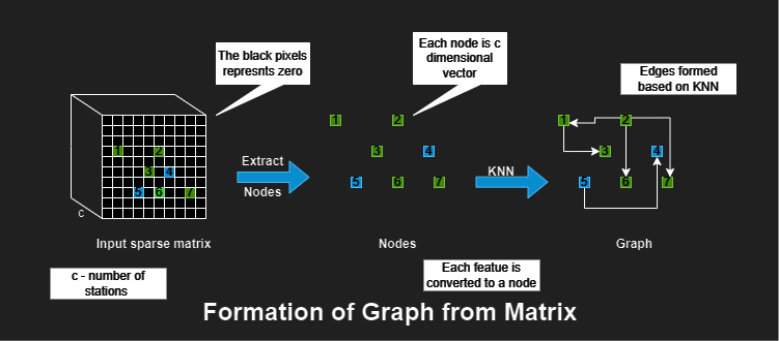

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------

- [ ] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**
- [x] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [16]:
# x_data.shape

In [17]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,7).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [18]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0),(0,2),(2,0),(2,4),(2,5),(2,6),(4,2),(5,2),(6,2)]

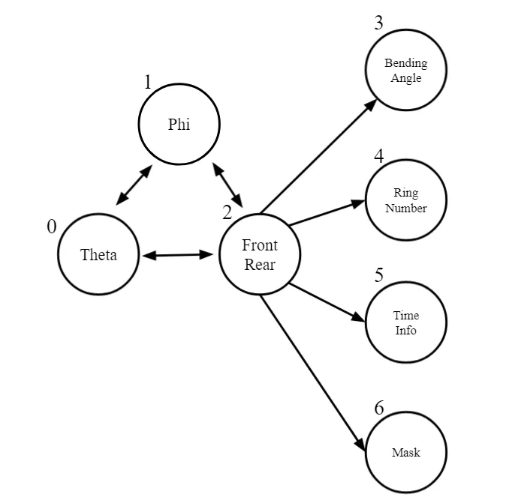

In [19]:
train_dataset = Graph_dataset(x_data, label, edge_index , train_idx)
next(iter(train_dataset))

Data(x=[7, 4], edge_index=[2, 14], y=9.726032257080078)

In [20]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=512)

In [21]:
next(iter(train_loader))

DataBatch(x=[7168, 4], edge_index=[2, 14336], y=[1024], batch=[7168], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [22]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = GCNConv(int(len(features)/7),128 )
        self.conv2 = GCNConv(128,64)
        self.conv3 = GCNConv(64,64 )
        self.conv4 = GCNConv(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [24]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [25]:
model

MODEL_GNN(
  (conv1): GCNConv(4, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [26]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('MSEError: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training pTLoss: ', train_loss, '| Testing pTLoss: ', test_loss)
        
        if prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [27]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

In [28]:
name =  f"4GCN_Conv_7nodes"

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from inf to 7.345832264087205
Epoch:  1/50 | Training pTLoss:  8.044265141973266 | Testing pTLoss:  7.345832264087205


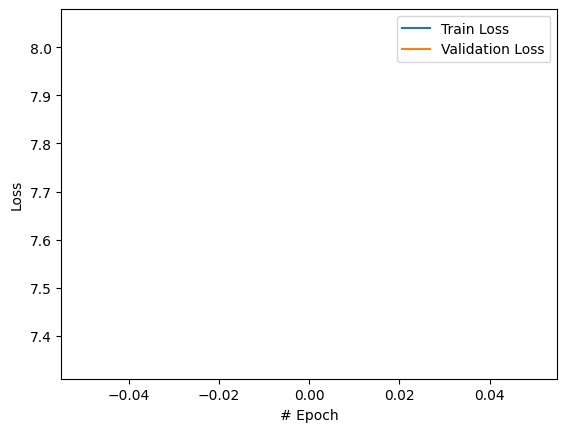

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 7.345832264087205 to 7.12661215850433
Epoch:  2/50 | Training pTLoss:  7.605041372801895 | Testing pTLoss:  7.12661215850433


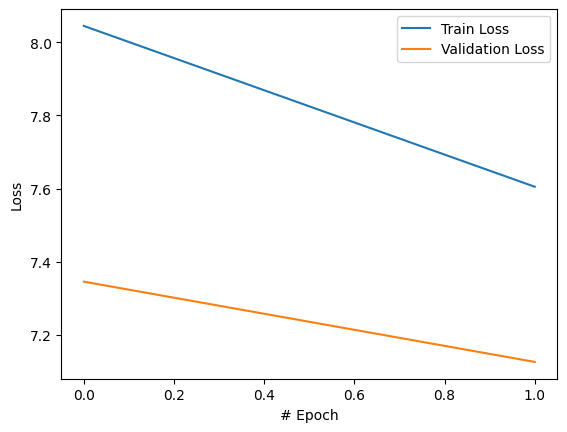

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 7.12661215850433 to 6.781626939256385
Epoch:  3/50 | Training pTLoss:  7.285422277036815 | Testing pTLoss:  6.781626939256385


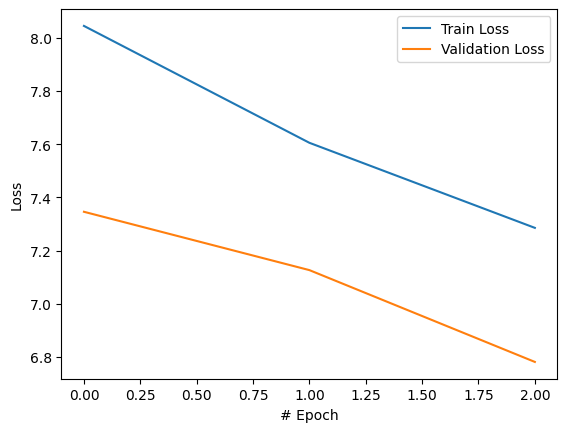

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.781626939256385 to 6.548077506253614
Epoch:  4/50 | Training pTLoss:  6.990112012482519 | Testing pTLoss:  6.548077506253614


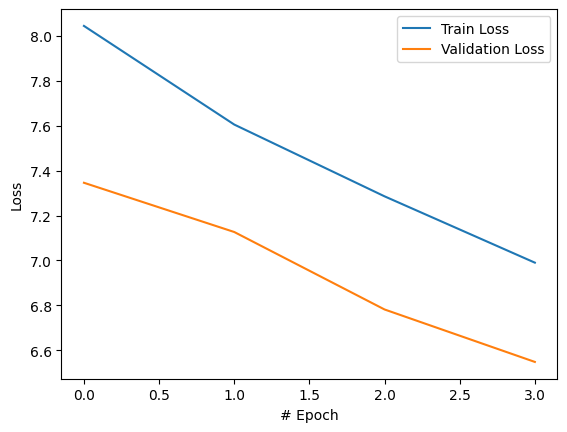

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.548077506253614 to 6.3882183314921255
Epoch:  5/50 | Training pTLoss:  6.740136649500013 | Testing pTLoss:  6.3882183314921255


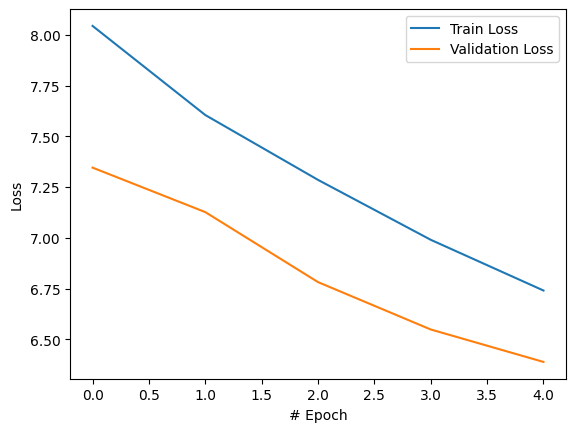

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.3882183314921255 to 6.174340891476051
Epoch:  6/50 | Training pTLoss:  6.49894194980506 | Testing pTLoss:  6.174340891476051


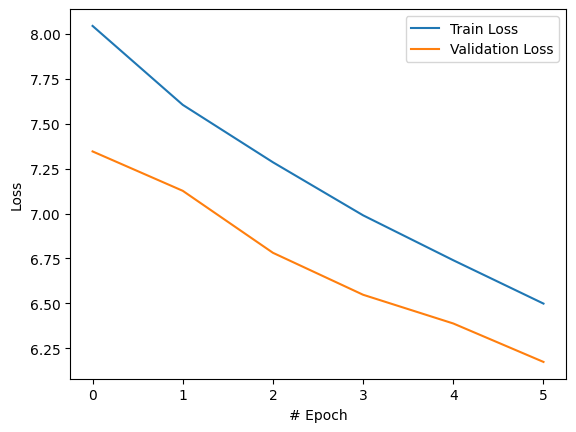

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 6.174340891476051 to 5.965783781188166
Epoch:  7/50 | Training pTLoss:  6.286980887555765 | Testing pTLoss:  5.965783781188166


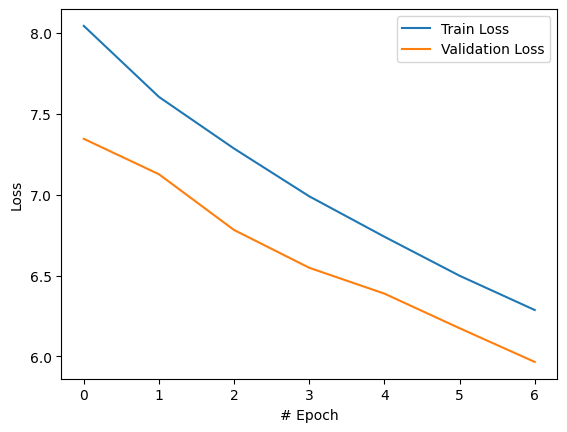

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.965783781188166 to 5.847844573267107
Epoch:  8/50 | Training pTLoss:  6.150863983367366 | Testing pTLoss:  5.847844573267107


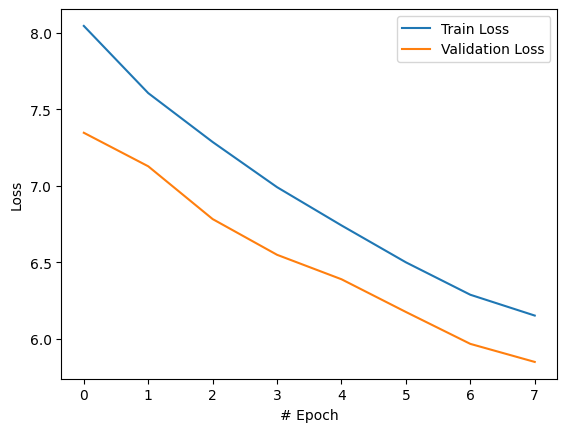

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.847844573267107 to 5.77574443506833
Epoch:  9/50 | Training pTLoss:  6.0652746342268005 | Testing pTLoss:  5.77574443506833


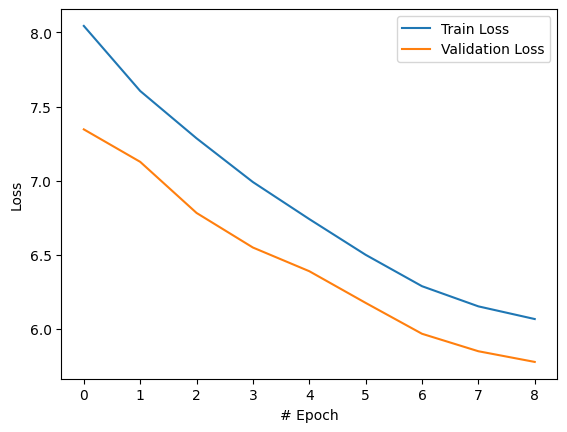

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.77574443506833 to 5.726853131213571
Epoch:  10/50 | Training pTLoss:  6.0012543661734075 | Testing pTLoss:  5.726853131213571


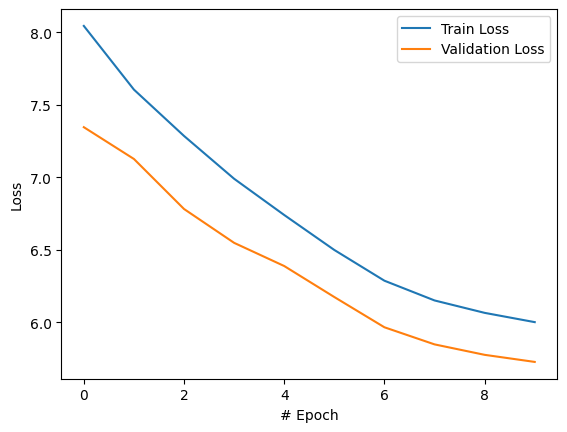

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.726853131213571 to 5.682284344820034
Epoch:  11/50 | Training pTLoss:  5.952251252797061 | Testing pTLoss:  5.682284344820034


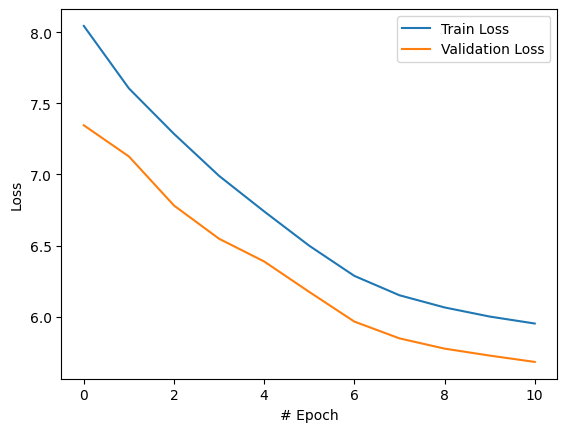

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.682284344820034 to 5.6476860868698076
Epoch:  12/50 | Training pTLoss:  5.904048528950538 | Testing pTLoss:  5.6476860868698076


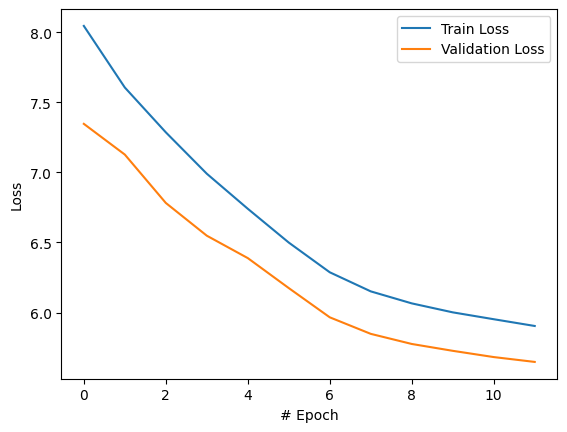

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.6476860868698076 to 5.590589946366182
Epoch:  13/50 | Training pTLoss:  5.852395597352385 | Testing pTLoss:  5.590589946366182


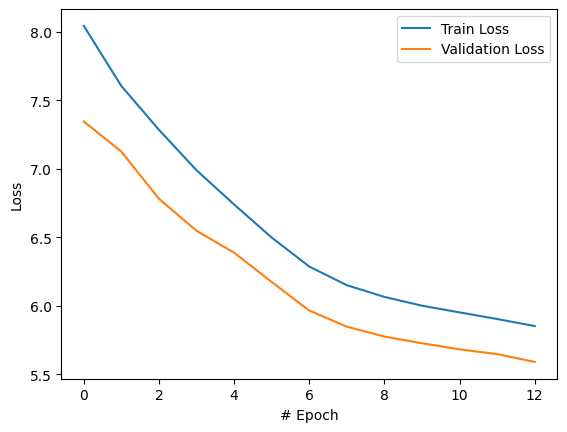

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.590589946366182 to 5.526586603446019
Epoch:  14/50 | Training pTLoss:  5.783629687644399 | Testing pTLoss:  5.526586603446019


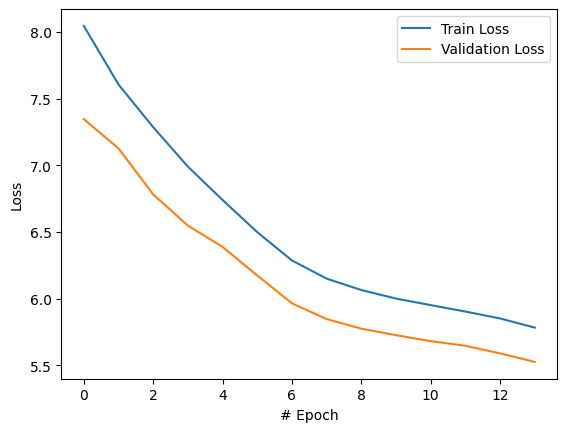

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.526586603446019 to 5.467725151014432
Epoch:  15/50 | Training pTLoss:  5.709372821960936 | Testing pTLoss:  5.467725151014432


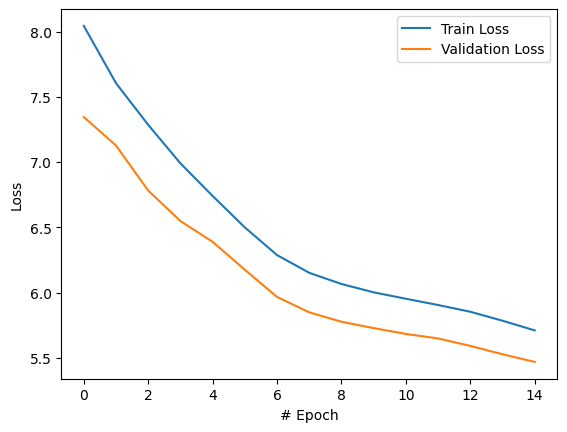

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.467725151014432 to 5.453277025719272
Epoch:  16/50 | Training pTLoss:  5.640409418145386 | Testing pTLoss:  5.453277025719272


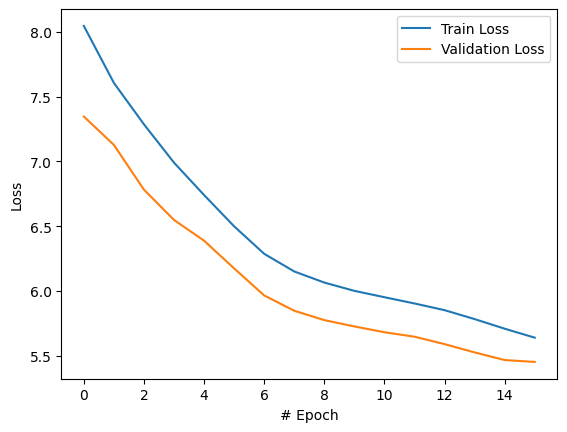

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.453277025719272 to 5.344383777092959
Epoch:  17/50 | Training pTLoss:  5.585076873059384 | Testing pTLoss:  5.344383777092959


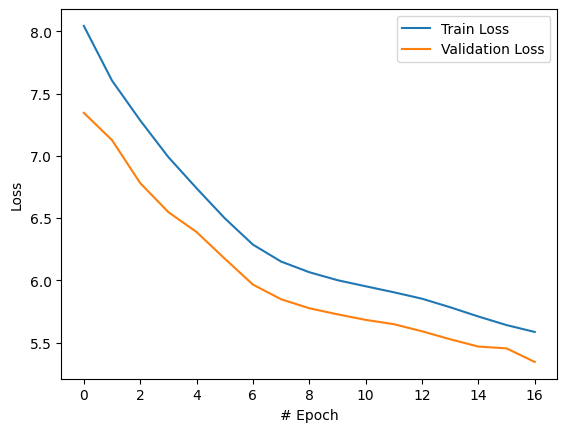

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.344383777092959 to 5.285397764141804
Epoch:  18/50 | Training pTLoss:  5.522716843642281 | Testing pTLoss:  5.285397764141804


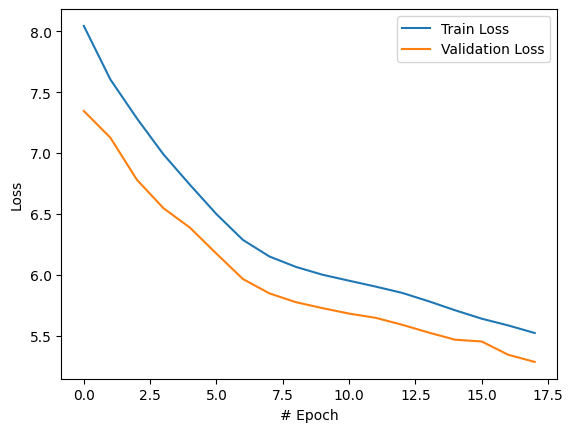

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.285397764141804 to 5.258507198987459
Epoch:  19/50 | Training pTLoss:  5.484671501947842 | Testing pTLoss:  5.258507198987459


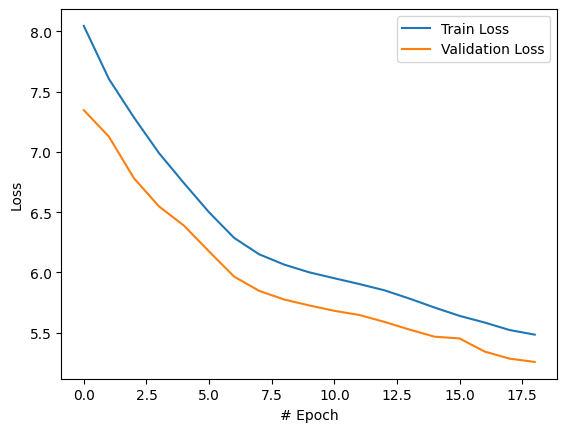

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.258507198987459 to 5.232810141724779
Epoch:  20/50 | Training pTLoss:  5.435425148610171 | Testing pTLoss:  5.232810141724779


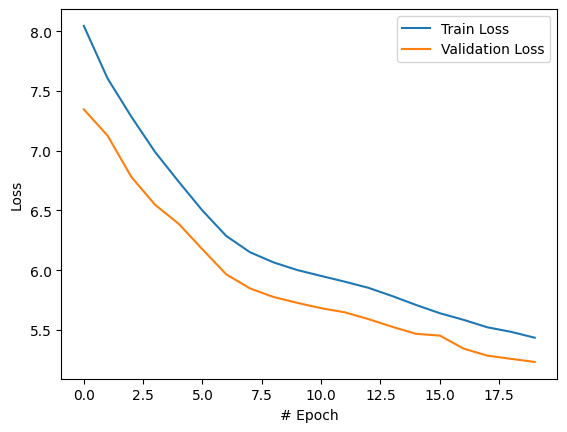

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.232810141724779 to 5.163766446961756
Epoch:  21/50 | Training pTLoss:  5.399488972479762 | Testing pTLoss:  5.163766446961756


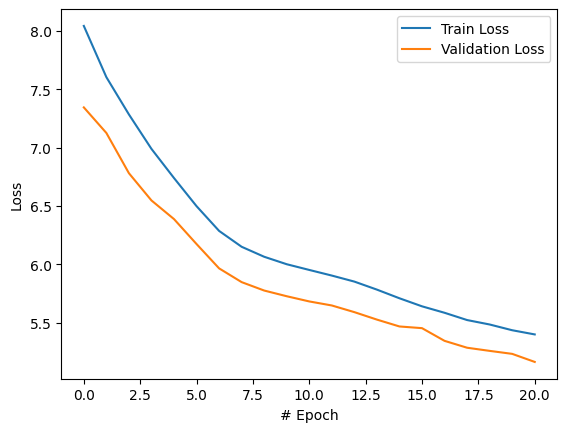

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.163766446961756 to 5.141727922019622
Epoch:  22/50 | Training pTLoss:  5.345580469243184 | Testing pTLoss:  5.141727922019622


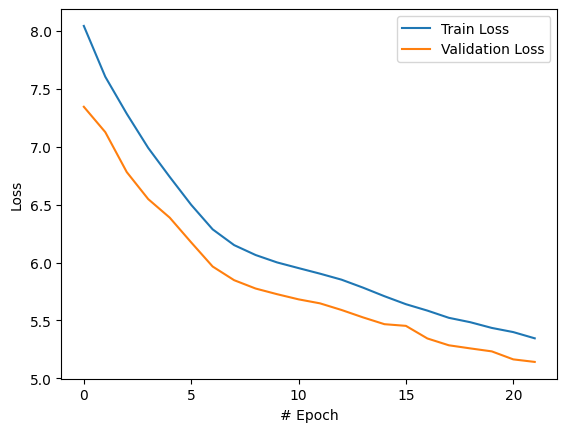

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  23/50 | Training pTLoss:  5.306145924549561 | Testing pTLoss:  5.205042259036328


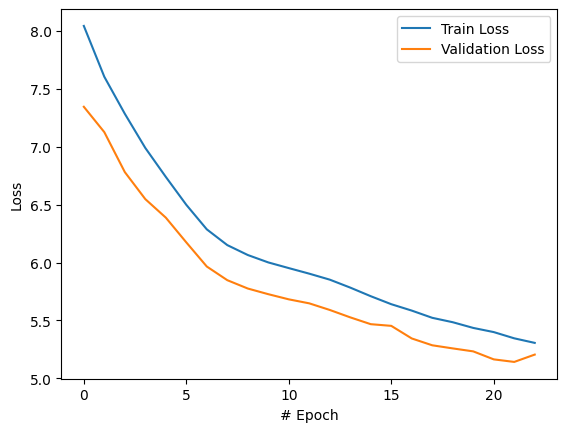

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.141727922019622 to 5.105562703469831
Epoch:  24/50 | Training pTLoss:  5.2661624627103025 | Testing pTLoss:  5.105562703469831


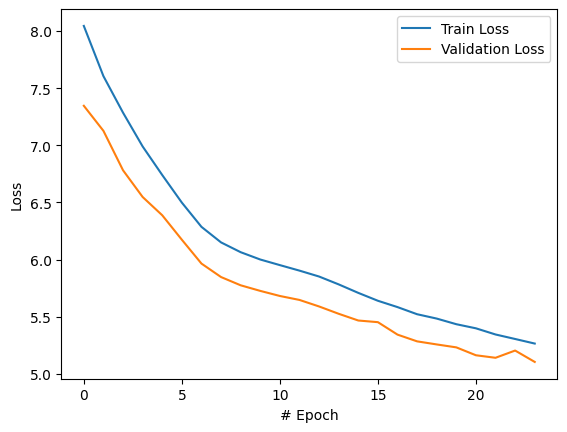

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.105562703469831 to 5.08470284188906
Epoch:  25/50 | Training pTLoss:  5.21686638642805 | Testing pTLoss:  5.08470284188906


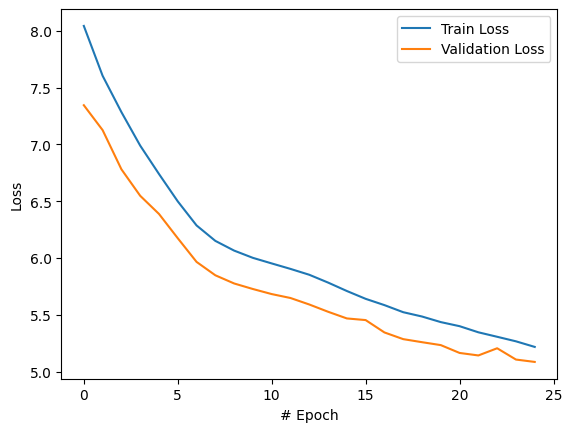

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.08470284188906 to 5.008150060626796
Epoch:  26/50 | Training pTLoss:  5.178120607409204 | Testing pTLoss:  5.008150060626796


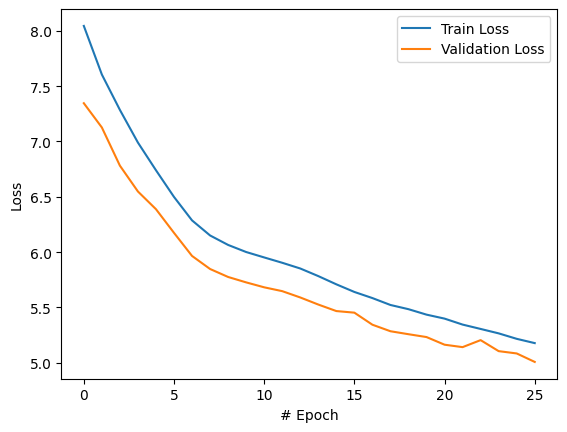

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 5.008150060626796 to 4.978416324954746
Epoch:  27/50 | Training pTLoss:  5.119808205813492 | Testing pTLoss:  4.978416324954746


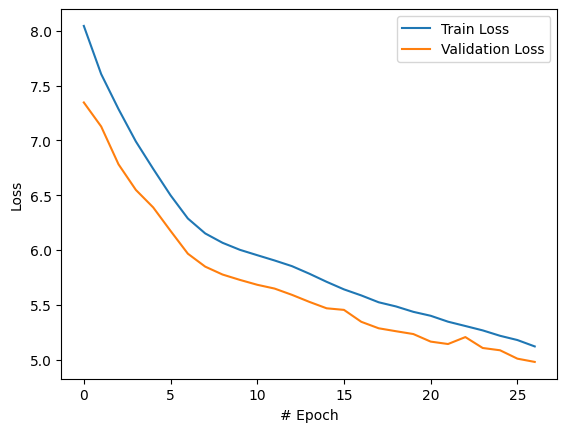

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.978416324954746 to 4.900362755885093
Epoch:  28/50 | Training pTLoss:  5.074899701130878 | Testing pTLoss:  4.900362755885093


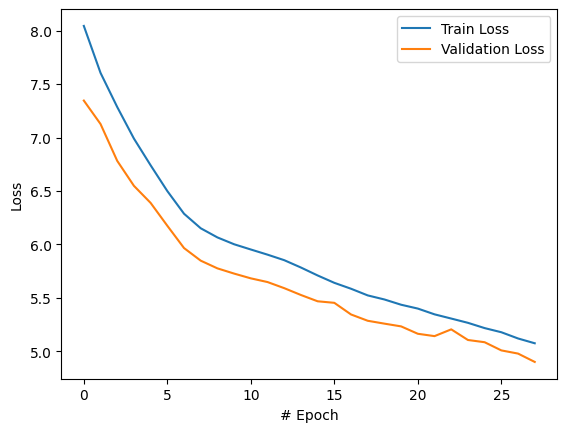

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.900362755885093 to 4.87408344709433
Epoch:  29/50 | Training pTLoss:  5.035780314251044 | Testing pTLoss:  4.87408344709433


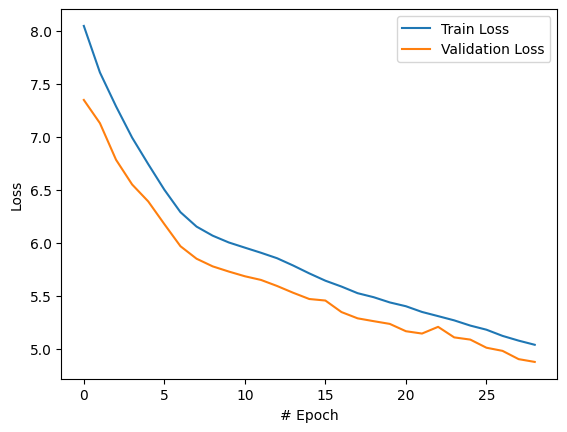

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.87408344709433 to 4.854058449542444
Epoch:  30/50 | Training pTLoss:  4.998586722930446 | Testing pTLoss:  4.854058449542444


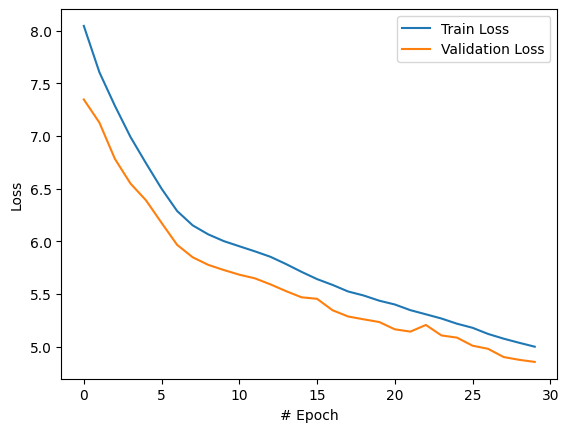

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.854058449542444 to 4.814383001234423
Epoch:  31/50 | Training pTLoss:  4.960652142698491 | Testing pTLoss:  4.814383001234423


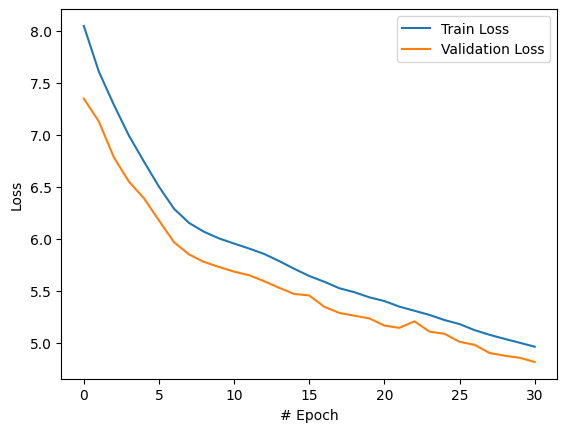

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.814383001234423 to 4.795390181582821
Epoch:  32/50 | Training pTLoss:  4.925812382760124 | Testing pTLoss:  4.795390181582821


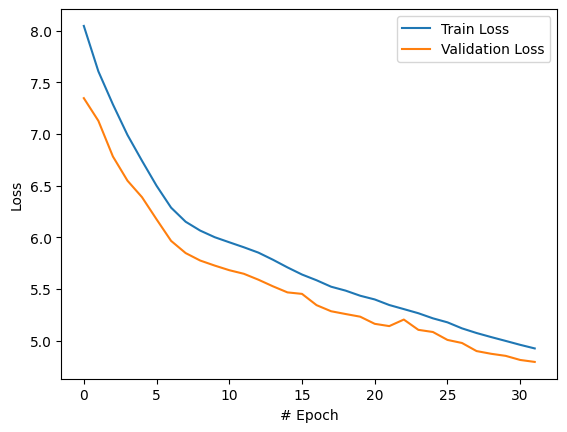

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.795390181582821 to 4.760208719723135
Epoch:  33/50 | Training pTLoss:  4.880413777140364 | Testing pTLoss:  4.760208719723135


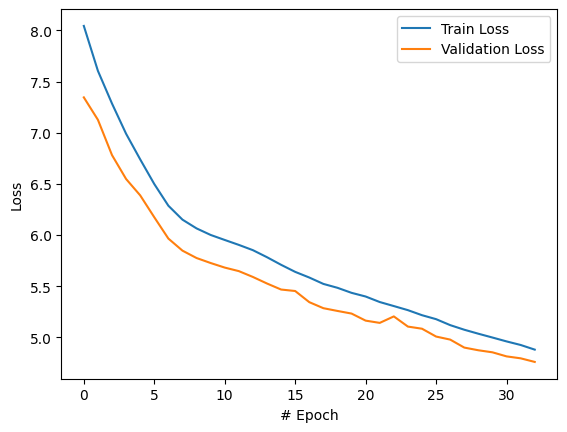

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.760208719723135 to 4.710614833293925
Epoch:  34/50 | Training pTLoss:  4.8535634760225665 | Testing pTLoss:  4.710614833293925


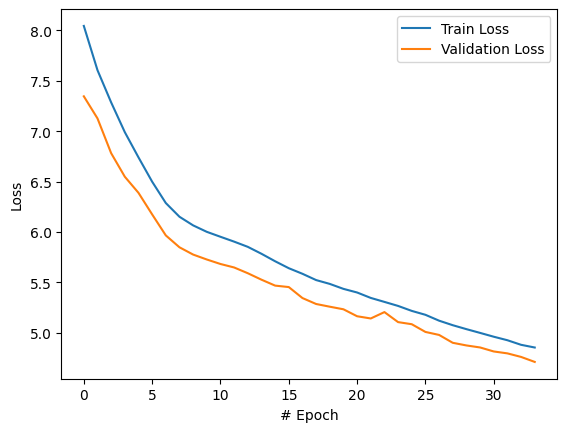

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  35/50 | Training pTLoss:  4.8292024973416225 | Testing pTLoss:  4.719386697074079


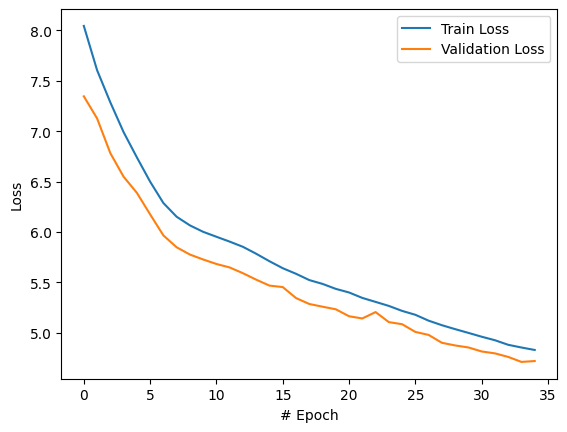

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  36/50 | Training pTLoss:  4.8051159549949025 | Testing pTLoss:  4.725227948641834


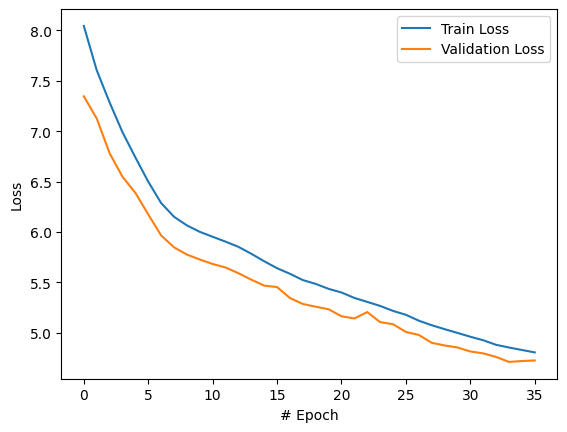

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.710614833293925 to 4.516593181647341
Epoch:  37/50 | Training pTLoss:  4.642356696201249 | Testing pTLoss:  4.516593181647341


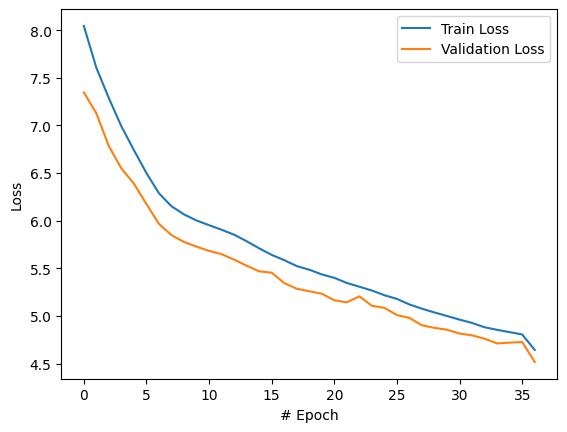

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.516593181647341 to 4.512394240517939
Epoch:  38/50 | Training pTLoss:  4.612229846304773 | Testing pTLoss:  4.512394240517939


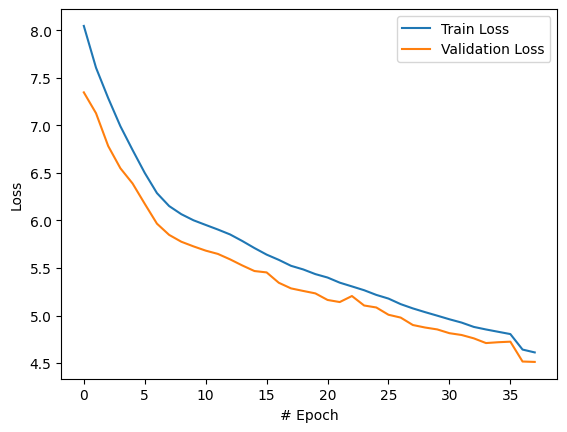

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.512394240517939 to 4.505664626326318
Epoch:  39/50 | Training pTLoss:  4.596577469542337 | Testing pTLoss:  4.505664626326318


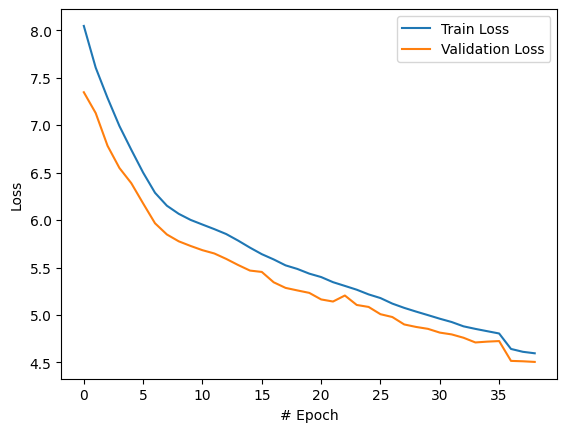

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.505664626326318 to 4.4720194740564345
Epoch:  40/50 | Training pTLoss:  4.581277218920031 | Testing pTLoss:  4.4720194740564345


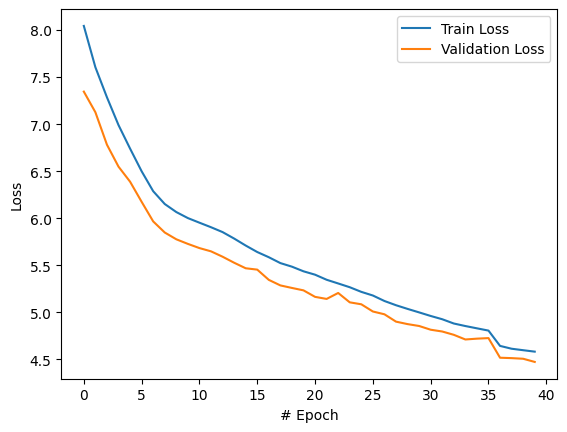

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  41/50 | Training pTLoss:  4.5657399005848545 | Testing pTLoss:  4.491098122844983


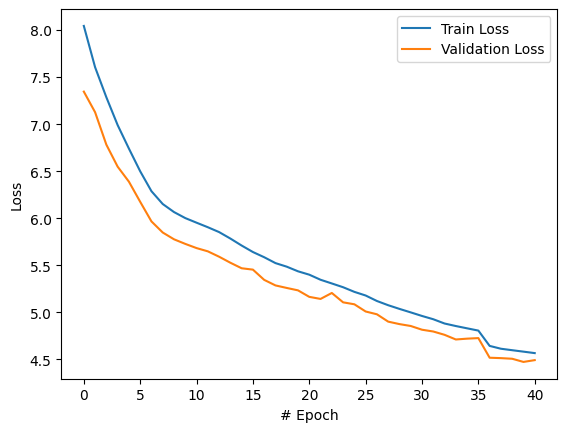

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  42/50 | Training pTLoss:  4.560257927197439 | Testing pTLoss:  4.48748200291408


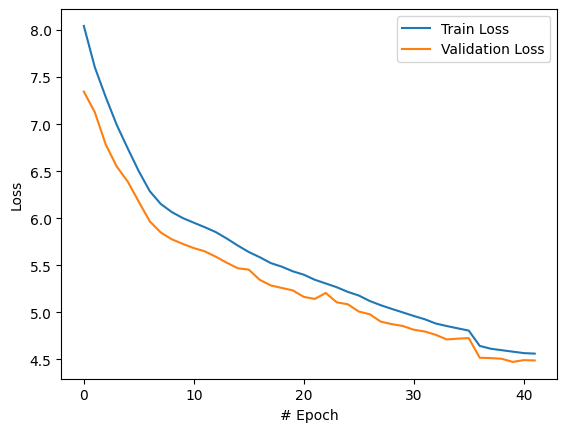

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.4720194740564345 to 4.415387909479619
Epoch:  43/50 | Training pTLoss:  4.472256671322143 | Testing pTLoss:  4.415387909479619


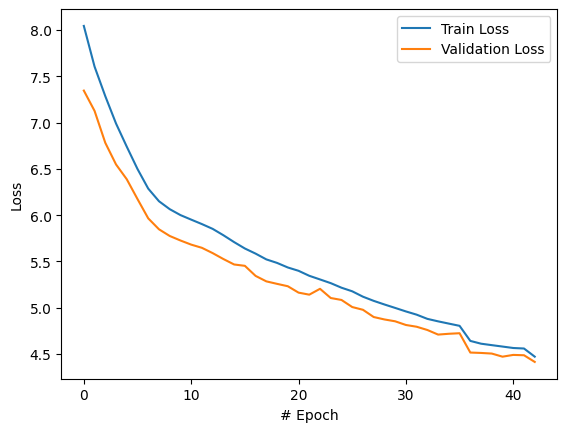

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.415387909479619 to 4.41155775120874
Epoch:  44/50 | Training pTLoss:  4.460358089842139 | Testing pTLoss:  4.41155775120874


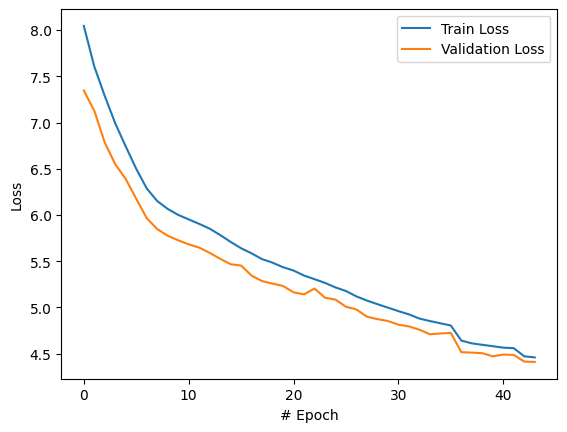

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.41155775120874 to 4.410438957803933
Epoch:  45/50 | Training pTLoss:  4.453708035439058 | Testing pTLoss:  4.410438957803933


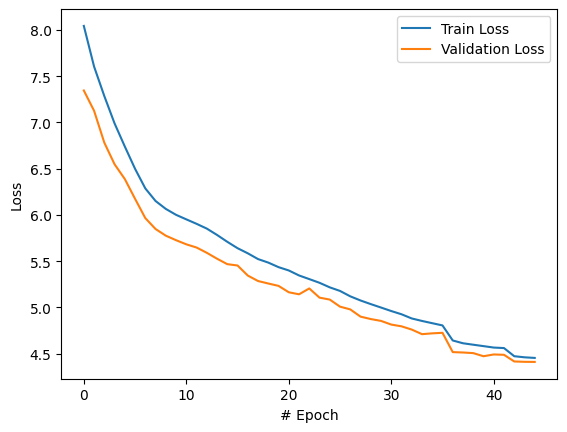

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.410438957803933 to 4.402095082007882
Epoch:  46/50 | Training pTLoss:  4.446259758994788 | Testing pTLoss:  4.402095082007882


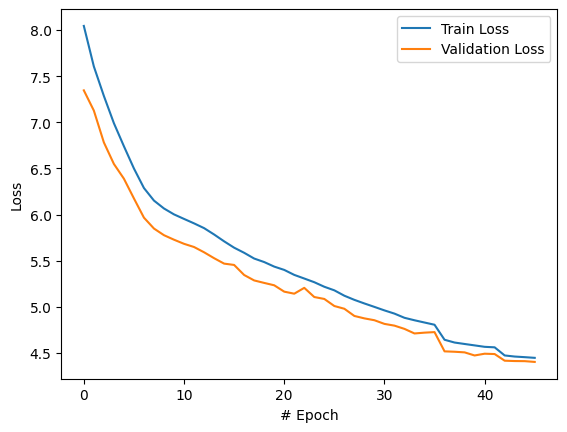

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  47/50 | Training pTLoss:  4.44044066949418 | Testing pTLoss:  4.407155713652327


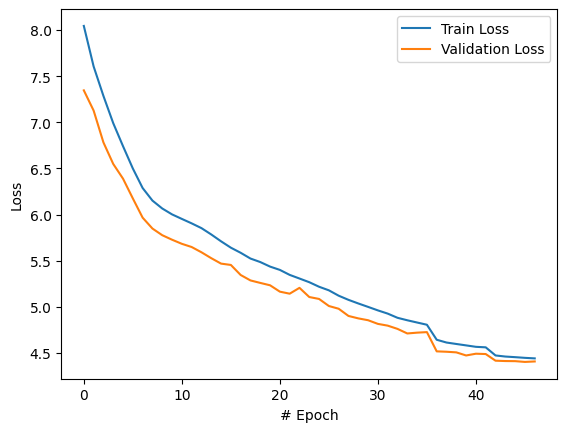

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.402095082007882 to 4.396937972294278
Epoch:  48/50 | Training pTLoss:  4.4351544386652675 | Testing pTLoss:  4.396937972294278


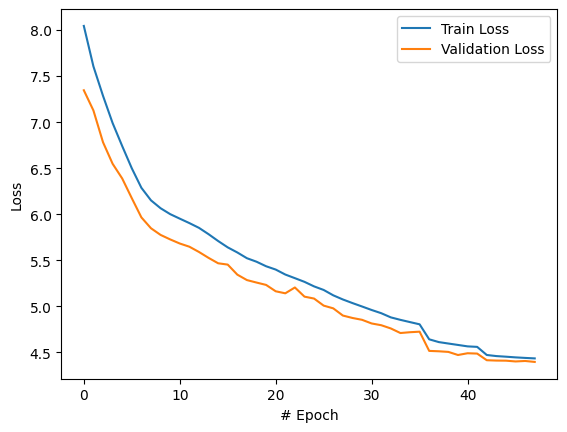

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  49/50 | Training pTLoss:  4.4300602652504235 | Testing pTLoss:  4.399079424698796


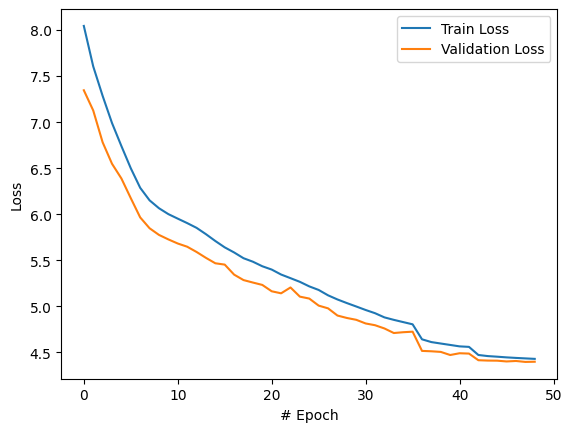

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.396937972294278 to 4.387854231153808
Epoch:  50/50 | Training pTLoss:  4.425666138820689 | Testing pTLoss:  4.387854231153808


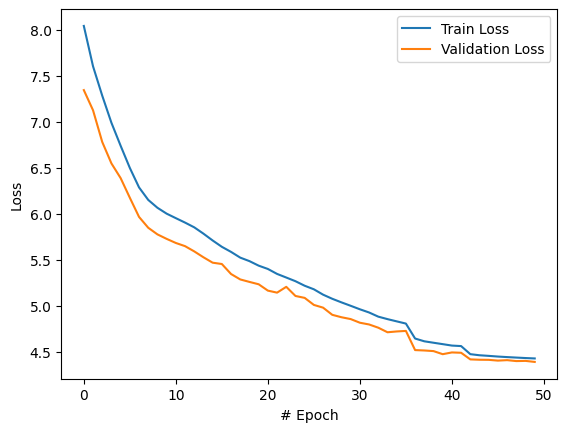

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

In [30]:
model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [31]:
test_los = 0
preds = []
true_labels = []
# criterion = nn.MSELoss()
for data in tqdm(test_loader, position=0):
    data = data.to(device)
    out = model(data)
    preds.append(out.cpu().detach().numpy())
    labels = data.y.cpu().detach().numpy()
    true_labels.append(labels)
    loss = pTLossTorch(out, data.y)
    test_los += loss.item() / len(test_loader)

# Convert lists to numpy arrays
preds = np.concatenate(preds, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate R2 score
r2 = r2_score(true_labels, preds)

print('Test Loss:', test_los)
print('R2 Score:', r2)

  0%|          | 0/461 [00:00<?, ?it/s]

Test Loss: 4.38785424304888
R2 Score: -0.049877853250372084
